In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb
from copy import copy

### Age profile of income 

In [2]:
## some life cycle paras 
T = 40
L = 60

T_q = T*4
L_q = L*4

In [3]:
def y2q_interpolate(xs_y):
    
    """
    this function turns an array of yealry rates into quarterly rates via linear interpolation 
    """

    n_y = len(xs_y)
    y_id = np.arange(n_y)
    q_id = y_id*4

    n_q = 4*n_y
    xs_q = np.empty(n_q)
    
    for i_y in range(n_y):
        xs_q[4*i_y] = xs_y[i_y]
        for i_q in np.arange(1,4):
            q_id_this = 4*i_y+i_q
            xs_q[q_id_this] = np.interp(q_id_this,q_id,xs_y)
            
    return xs_q

In [4]:
age_profile = pd.read_stata('../OtherData/age_profile.dta')  

In [5]:
age_profile_data ='SIPP'

if age_profile_data=='SIPP':
    ## import age income profile 

    age_profile = pd.read_stata('../OtherData/age_profile.dta')   

    ## select age range for the model and turn it into an array 
    lc_wages = np.array(age_profile[(age_profile['age']>=24) &(age_profile['age']<=64)]['wage_age'])
    #print(str(len(lc_wages)),'years since age 25')

    ## growth rates since initial age over life cicle before retirement
    lc_G = lc_wages[1:]/lc_wages[:-1]

    ## growth rates after retirement

    lc_G_rt = np.ones(L-T)
    lc_G_rt[0] = 1/np.cumprod(lc_G)[-1]


    lc_G_full = np.concatenate([lc_G,lc_G_rt])
    assert len(lc_G_full) == L,'length of G needs to be equal to L'
    #lc_G_full = np.ones_like(lc_G_full)

    
    ## turn yearly number to quarterly number with interpolation 

    ## get the quarterly income profile over life cycle before retirement 
    lc_G_q = y2q_interpolate(lc_G)

    lc_G_q_rt = y2q_interpolate(lc_G_rt)

    lc_G_q_full = np.concatenate([lc_G_q,lc_G_q_rt])
    
    
elif age_profile_data=='SCF':
    ## import age income profile 
    SCF_profile = pd.read_pickle('data/SCF_age_profile.pkl')
    SCF_profile = SCF_profile[(SCF_profile.index>=24) & (SCF_profile.index<=85)]
    lc_p_incom = np.exp(np.array(SCF_profile['av_lnorminc']))
    lc_G_full = lc_p_incom[1:]/lc_p_incom[:-1] 
    assert len(lc_G_full) == L,'length of G needs to be equal to L'
    lc_G_q_full = y2q_interpolate(lc_G_full)


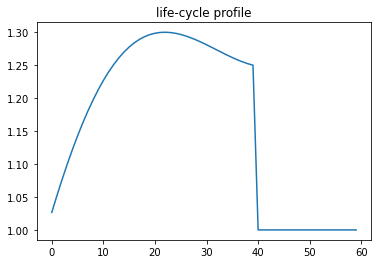

In [6]:
if __name__ == "__main__":
    plt.title('life-cycle profile')
    plt.plot(np.cumprod(lc_G_full))

### Income risk estimates 

In [7]:
risks_est = pd.read_stata('../OtherData/sipp/sipp_history_vol_decomposed.dta')
## risks of permanent and transitory component 

σ_ψ_q_sipp = np.sqrt(risks_est['permanent']**2*3)
σ_θ_q_sipp = np.sqrt(risks_est['permanent']**2/3)

## p/t ratio 
kappas_sipp  = risks_est['permanent']/risks_est['transitory']
kappa_sipp = np.median(kappas_sipp.dropna())

In [8]:
## risks of permanent and transitory component 

σ_ψ_q_sipp = np.sqrt(risks_est['permanent']**2*3)
σ_θ_q_sipp = np.sqrt(risks_est['permanent']**2/3)

## p/t ratio 
kappas_sipp  = risks_est['permanent']/risks_est['transitory']
kappa_sipp = np.median(kappas_sipp.dropna())

### Initial conditions

In [9]:
from statsmodels.stats.weightstats import DescrStatsW

## SCF data 
SCF2016 = pd.read_stata('rscfp2016.dta')
SCF2016 = SCF2016[SCF2016['age']==25]
SCF2016 = SCF2016.drop_duplicates(subset=['yy1'])
SCF2016 = SCF2016[['norminc','networth','wgt']]
SCF2016 = SCF2016[SCF2016['norminc']>0]

## permanent income at age 25 
pinc_SCF = SCF2016[['norminc','wgt']]
lpinc_SCF_pos, lpinc_SCF_wgt = np.log(pinc_SCF['norminc']),np.array(pinc_SCF['wgt'])

## wealth 
b_SCF = SCF2016[['networth','wgt']]
lb_SCF_pos, lb_SCF_wgt = b_SCF['networth'],np.array(b_SCF['wgt'])

## wealth to permanent income
SCF2016['networth2pinc'] = SCF2016['networth']/SCF2016['norminc']
b_SCF, b_wgt = SCF2016['networth2pinc'], SCF2016['wgt']

## compute data moments 
σ_ψ_init_SCF = DescrStatsW(lpinc_SCF_pos, weights=lpinc_SCF_wgt, ddof=1).std
σ_b_init_SCF = DescrStatsW(lb_SCF_pos, weights=lb_SCF_wgt, ddof=1).std
b_SCF = DescrStatsW(b_SCF,weights=b_wgt, ddof=1).mean ## annual 
b_q_SCF = b_SCF*4  ## quarterly  

### subjective profile estiamtion 

In [10]:
## import subjective profile estimation results 
SCE_est_q = pd.read_pickle('data/subjective_profile_est_q.pkl')
SCE_est_y = pd.read_pickle('data/subjective_profile_est_y.pkl')
SCE_est_q = SCE_est_q['baseline']
SCE_est_y = SCE_est_y['baseline']

In [11]:
## create a dictionary of parameters 
life_cycle_paras_q = {'ρ': 1.0, 
                    'β': 0.98**(1/4), 
                    'P': np.array([[0.18, 0.82],
                                   [0.04, 0.96]]), 
                    'z_val': np.array([0., 1.]), 
                    'σ_ψ': np.sqrt(0.15**2*4/11), 
                    'σ_θ': np.sqrt(0.1**2*4), 
                    'U': 0.0, 
                    'LivPrb': 1.0-0.00625, 
                    'R': 1.01**(1/4), 
                    'W': 1.0, 
                    'T': T_q, 
                    'L': L_q, 
                    'G':lc_G_q_full, 
                    'unemp_insurance': 0.15, 
                    'pension': 0.65, 
                    'σ_ψ_init': σ_ψ_init_SCF, 
                    'init_b': b_q_SCF, 
                    'λ': 0.0, 
                    'λ_SS': 0.0, 
                    'transfer': 0.0, 
                    'bequest_ratio': 0.0,
                    'κ':kappa_sipp,
                    
                    ## subjective profile
                    'q':SCE_est_q.loc['$q$'],
                    'p':SCE_est_q.loc['$p$'],
                    'σ_ψ_2mkv':np.array([SCE_est_q.loc['$\tilde\sigma^l_\psi$'],
                                       SCE_est_q.loc['$\tilde\sigma^h_\psi$']]),
                    'σ_θ_2mkv':np.array([SCE_est_q.loc['$\tilde\sigma^l_\theta$'],
                                       SCE_est_q.loc['$\tilde\sigma^h_\theta$']]),
                    'mho_2mkv':np.array([SCE_est_q.loc['$\tilde \mho^l$'],
                                         SCE_est_q.loc['$\tilde \mho^h$']]),
                    'E_2mkv':np.array([SCE_est_q.loc['$\tilde E^l$'],
                                      SCE_est_q.loc['$\tilde E^h$']])
                }

In [12]:
life_cycle_paras_q

{'ρ': 1.0,
 'β': 0.9949620563926881,
 'P': array([[0.18, 0.82],
        [0.04, 0.96]]),
 'z_val': array([0., 1.]),
 'σ_ψ': 0.09045340337332908,
 'σ_θ': 0.2,
 'U': 0.0,
 'LivPrb': 0.99375,
 'R': 1.0024906793143211,
 'W': 1.0,
 'T': 160,
 'L': 240,
 'G': array([1.02654111, 1.02611676, 1.0256924 , 1.02526805, 1.02484369,
        1.02443039, 1.0240171 , 1.0236038 , 1.0231905 , 1.02278841,
        1.02238631, 1.02198422, 1.02158213, 1.02119136, 1.02080059,
        1.02040982, 1.02001905, 1.01963976, 1.01926047, 1.01888117,
        1.01850188, 1.01813418, 1.01776648, 1.01739877, 1.01703107,
        1.01667506, 1.01631904, 1.01596302, 1.015607  , 1.01526287,
        1.01491874, 1.01457462, 1.01423049, 1.0138984 , 1.01356632,
        1.01323423, 1.01290214, 1.01258209, 1.01226205, 1.011942  ,
        1.01162195, 1.01131424, 1.01100653, 1.01069883, 1.01039112,
        1.01009578, 1.00980043, 1.00950509, 1.00920975, 1.00892699,
        1.00864422, 1.00836146, 1.00807869, 1.00780857, 1.00753844,


In [13]:
## create a dictionary of parameters 
life_cycle_paras_y = {'ρ': 1.0, 
                    'β': 0.98, 
                    'P': np.array([[0.18, 0.82],
                                   [0.04, 0.96]]), 
                    'z_val': np.array([0., 1.]), 
                    'σ_ψ': np.sqrt(0.15**2), 
                    'σ_θ': np.sqrt(0.1**2), 
                    'U': 0.0, 
                    'LivPrb': 1.0-0.00625, 
                    'R': 1.01, 
                    'W': 1.0, 
                    'T': T, 
                    'L': L, 
                    'G':lc_G_full, 
                    'unemp_insurance': 0.15, 
                    'pension': 0.65, 
                    'σ_ψ_init': σ_ψ_init_SCF, 
                    'init_b': b_SCF, 
                    'λ': 0.0, 
                    'λ_SS': 0.0, 
                    'transfer': 0.0, 
                    'bequest_ratio': 0.0,
                    'κ':kappa_sipp,
                    
                    ## subjective profile
                    'q':SCE_est_y.loc['$q$'],
                    'p':SCE_est_y.loc['$p$'],
                    'σ_ψ_2mkv':np.array([SCE_est_y.loc['$\tilde\sigma^l_\psi$'],
                                       SCE_est_y.loc['$\tilde\sigma^h_\psi$']]),
                    'σ_θ_2mkv':np.array([SCE_est_y.loc['$\tilde\sigma^l_\theta$'],
                                       SCE_est_y.loc['$\tilde\sigma^h_\theta$']]),
                    'mho_2mkv':np.array([SCE_est_y.loc['$\tilde \mho^l$'],
                                         SCE_est_y.loc['$\tilde \mho^h$']]),
                    'E_2mkv':np.array([SCE_est_y.loc['$\tilde E^l$'],
                                      SCE_est_y.loc['$\tilde E^h$']])
                }

In [14]:
life_cycle_paras_y

{'ρ': 1.5,
 'β': 0.98,
 'P': array([[0.18, 0.82],
        [0.04, 0.96]]),
 'z_val': array([0., 1.]),
 'σ_ψ': 0.15,
 'σ_θ': 0.1,
 'U': 0.0,
 'LivPrb': 0.99375,
 'R': 1.01,
 'W': 1.0,
 'T': 40,
 'L': 60,
 'G': array([1.02654111, 1.02484369, 1.0231905 , 1.02158213, 1.02001905,
        1.01850188, 1.01703107, 1.015607  , 1.01423049, 1.01290214,
        1.01162195, 1.01039112, 1.00920975, 1.00807869, 1.00699818,
        1.00596917, 1.00499189, 1.00406706, 1.00319529, 1.00237691,
        1.0016129 , 1.00090361, 1.00024962, 0.99965161, 0.99911016,
        0.99862605, 0.99819976, 0.99783188, 0.99752331, 0.99727446,
        0.99708599, 0.99695873, 0.99689335, 0.99689043, 0.99695092,
        0.99707526, 0.99726444, 0.99751896, 0.99783993, 0.99822766,
        0.80030506, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1

### Production function parameters 

In [15]:
production_paras_y={}
production_paras_y['K2Y ratio'] = 3.0
production_paras_y['W'] = 1.0
production_paras_y['α'] = 0.33
production_paras_y['δ'] = 0.025

In [16]:
## quarterly paras 
production_paras_q = copy(production_paras_y)
production_paras_q['K2Y ratio'] = production_paras_q['K2Y ratio']*4

### Export the parameters into a table used in the draft

In [17]:
life_cycle_paras_y_copy = copy(life_cycle_paras_y)

In [18]:
del life_cycle_paras_y_copy['G']  
del life_cycle_paras_y_copy['σ_ψ_2mkv']  
del life_cycle_paras_y_copy['σ_θ_2mkv']  
del life_cycle_paras_y_copy['mho_2mkv']  
del life_cycle_paras_y_copy['E_2mkv']  
del life_cycle_paras_y_copy['P']  
del life_cycle_paras_y_copy['z_val']  
del life_cycle_paras_y_copy['U']  
del life_cycle_paras_y_copy['κ']  
del life_cycle_paras_y_copy['q']  
del life_cycle_paras_y_copy['p']  
del life_cycle_paras_y_copy['transfer']  


## rewrite some parameters' names

life_cycle_paras_y_copy['U2U'] = life_cycle_paras_y['P'][0,0]
life_cycle_paras_y_copy['E2E'] = life_cycle_paras_y['P'][1,1]

## rename some 
life_cycle_paras_y_copy['1-D'] =  life_cycle_paras_y_copy.pop('LivPrb')
life_cycle_paras_y_copy['μ'] =  life_cycle_paras_y_copy.pop('unemp_insurance')
life_cycle_paras_y_copy['b_init'] =  life_cycle_paras_y_copy.pop('init_b')

## rounding 
life_cycle_paras_y_copy['1-D'] = round(life_cycle_paras_y_copy['1-D'],3)
life_cycle_paras_y_copy['σ_ψ_init'] = round(life_cycle_paras_y_copy['σ_ψ_init'],3)
life_cycle_paras_y_copy['b_init'] = round(life_cycle_paras_y_copy['b_init'],3)

In [19]:
## merge life-cycle and production paras into model paras

model_paras = copy(life_cycle_paras_y_copy)
model_paras.update(production_paras_y)

In [20]:
model_paras

{'ρ': 1.5,
 'β': 0.98,
 'σ_ψ': 0.15,
 'σ_θ': 0.1,
 'R': 1.01,
 'W': 1.0,
 'T': 40,
 'L': 60,
 'pension': 0.6,
 'σ_ψ_init': 0.629,
 'λ': 0.0,
 'λ_SS': 0.0,
 'bequest_ratio': 0.0,
 'U2U': 0.18,
 'E2E': 0.96,
 '1-D': 0.994,
 'μ': 0.15,
 'b_init': 0.554,
 'K2Y ratio': 3.0,
 'α': 0.33,
 'δ': 0.025}

In [21]:
# making blocks 

blocknames =['risk',
            'initial condition',
            'life cycle',
            'preference',
            'policy',
            'production']

prefernece = ['ρ','β']
lifecycle = ['T','L','1-D']
risk  = ['σ_ψ','σ_θ','U2U','E2E']
initial = ['σ_ψ_init','init_b','bequest_ratio']
policy = ['μ','pension','λ','λ_SS']
production=['K2Y ratio','W','α','δ']

block_all= [risk,
            initial,
            lifecycle,
            prefernece,
            policy,
           production]

## create multiple layer dictionary 

model_paras_by_block = {}

for i,block in enumerate(block_all):
    model_paras_by_block[blocknames[i]] =  {k: v for k, v 
                                               in model_paras.items() 
                                               if k in block}

In [22]:
model_paras_by_block

{'risk': {'σ_ψ': 0.15, 'σ_θ': 0.1, 'U2U': 0.18, 'E2E': 0.96},
 'initial condition': {'σ_ψ_init': 0.629, 'bequest_ratio': 0.0},
 'life cycle': {'T': 40, 'L': 60, '1-D': 0.994},
 'preference': {'ρ': 1.5, 'β': 0.98},
 'policy': {'pension': 0.6, 'λ': 0.0, 'λ_SS': 0.0, 'μ': 0.15},
 'production': {'W': 1.0, 'K2Y ratio': 3.0, 'α': 0.33, 'δ': 0.025}}

In [23]:
model_paras_by_block_df = pd.DataFrame.from_dict({(i,j): model_paras_by_block[i][j] 
                           for i in model_paras_by_block.keys() 
                           for j in model_paras_by_block[i].keys()},
                       orient='index')

model_paras_by_block_df.columns =['values']
Mindex = pd.MultiIndex.from_tuples(list(model_paras_by_block_df.index), names=["block", "parameter"])
model_paras_by_block_df.index = Mindex

In [24]:
model_paras_by_block_df['source']=''

In [25]:
model_paras_by_block_df

values source
block             parameter                   
risk              σ_ψ             0.150       
                  σ_θ             0.100       
                  U2U             0.180       
                  E2E             0.960       
initial condition σ_ψ_init        0.629       
                  bequest_ratio   0.000       
life cycle        T              40.000       
                  L              60.000       
                  1-D             0.994       
preference        ρ               1.500       
                  β               0.980       
policy            pension         0.600       
                  λ               0.000       
                  λ_SS            0.000       
                  μ               0.150       
production        W               1.000       
                  K2Y ratio       3.000       
                  α               0.330       
                  δ               0.025

In [26]:
## add source of the parameters 

model_paras_by_block_df.loc['risk','source']='Median estimates from the literature'
model_paras_by_block_df.loc['initial condition','source']='Estimated for age 25 in the 2016 SCF'
model_paras_by_block_df.loc[('initial condition','bequest_ratio'),'source']='assumption'
model_paras_by_block_df.loc['life cycle','source']='standard assumption'
model_paras_by_block_df.loc['preference','source']='standard assumption'
model_paras_by_block_df.loc['policy','source']='U.S. average'
model_paras_by_block_df.loc[('policy','λ'),'source']='endogenously determined'
model_paras_by_block_df.loc[('policy','λ_SS'),'source']='endogenously determined'

model_paras_by_block_df.loc['production','source']='standard assumption'
model_paras_by_block_df.loc[('production','W'),'source']='target values in steady state'
model_paras_by_block_df.loc[('production','K2Y ratio'),'source']='target values in steady state'

In [27]:
## for latex symbols 
parameter_list = [para[1] for para in list(model_paras_by_block_df.index)]

para_latex = ['$\\sigma_\\psi$',
              '$\\sigma_\\theta$',
              '$U2U$',
              '$E2E$',
              '$\\sigma_\\psi^{\\text{init}}$',
              'bequest ratio',
              '$T$',
              '$L$',
              '$1-D$',
              '$\\rho$',
              '$\\beta$',
              '$\\mathbb{S}$',
             '$\\lambda$',
             '$\\lambda_{SS}$',
             '$\\mu$',
             '$W$',
             'K2Y ratio',
             '$\\alpha$',
             '$\\delta$']

model_paras_by_block_df['parameter name']= para_latex

model_paras_by_block_df = model_paras_by_block_df[['parameter name','values','source']]

model_paras_by_block_df=model_paras_by_block_df.reset_index(level=1, drop=True)

In [28]:
## export to excel 
model_paras_by_block_df.to_excel('../Tables/calibration.xlsx')

In [29]:
model_paras_by_block_df

,parameter name,values,source
block,,,
risk,$\sigma_\psi$,0.150,Median estimates from the literature
risk,$\sigma_\theta$,0.100,Median estimates from the literature
risk,$U2U$,0.180,Median estimates from the literature
risk,$E2E$,0.960,Median estimates from the literature
initial condition,$\sigma_\psi^{\text{init}}$,0.629,Estimated for age 25 in the 2016 SCF
initial condition,bequest ratio,0.000,assumption
life cycle,$T$,40.000,standard assumption
life cycle,$L$,60.000,standard assumption
life cycle,$1-D$,0.994,standard assumption
